# Tennis Match Prediction with Graph Neural Networks

**Author:** [Donato Festa]
**Course:** Machine Learning, Computer Science Master's Degree
**Objective:** This project aims to develop and evaluate a Graph Neural Network (GNN) for predicting the outcome of professional men's tennis matches. Its performance will be rigorously compared against a strong, feature-engineered XGBoost baseline to determine if a relational approach can capture predictive information beyond traditional metrics.

## Section 1: Data Loading and Exploratory Data Analysis (EDA)

The foundation of any machine learning project is a thorough understanding of the data. In this section, we load the dataset, perform initial cleaning, and conduct an Exploratory Data Analysis (EDA) to uncover key patterns and insights that will inform our modeling decisions.

The data is sourced from Jeff Sackmann's comprehensive match-by-match statistics repository, covering all ATP tour matches from the year 2000 onwards.

In [1]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Add project root to Python path
try:
    project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
except NameError:
    project_root = os.path.abspath(os.path.join('.', '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Import our custom data loader
from src.data_processing.data_loader import load_and_prepare_data

# Load the data using our function
try:
    df = load_and_prepare_data(path_pattern="../data/tennis_atp/atp_matches_*.csv")

    # Display basic information about the loaded dataset
    print("\n--- Dataset Overview ---")
    print(f"Total number of matches loaded: {len(df)}")
    print(f"Time range: {df['tourney_date'].min().year} to {df['tourney_date'].max().year}")
    
    # Display a sample of the data
    print("\nSample of the data:")
    display(df[['tourney_date', 'tourney_name', 'surface', 'winner_name', 'loser_name', 'winner_rank', 'loser_rank', 'score']].head())

except FileNotFoundError:
    print("Error: Data files not found. Please ensure the 'data/tennis_atp' directory is correctly placed.")

--- Section 1: Loading and Preparing Raw Data ---
Loading 25 files from year 2000 onwards...
Loaded 74906 matches.
Data loading and basic preparation complete.

--- Dataset Overview ---
Total number of matches loaded: 74906
Time range: 2000 to 2024

Sample of the data:


,tourney_date,tourney_name,surface,winner_name,loser_name,winner_rank,loser_rank,score
0,2000-01-03,Adelaide,Hard,Thomas Enqvist,Arnaud Clement,4.0,56.0,6-3 6-4
1,2000-01-03,Doha,Hard,Nicolas Kiefer,Jeff Tarango,6.0,55.0,7-6(6) 7-6(6)
2,2000-01-03,Chennai,Hard,Michal Tabara,Yevgeny Kafelnikov,123.0,2.0,6-4 6-2
3,2000-01-03,Adelaide,Hard,Roger Federer,Jens Knippschild,64.0,91.0,6-1 6-4
4,2000-01-03,Doha,Hard,Cristiano Caratti,Ivo Heuberger,213.0,221.0,7-6(4) 4-6 6-4


### 1.1 Key Data Distributions

We begin by visualizing some high-level properties of our dataset to understand its composition.

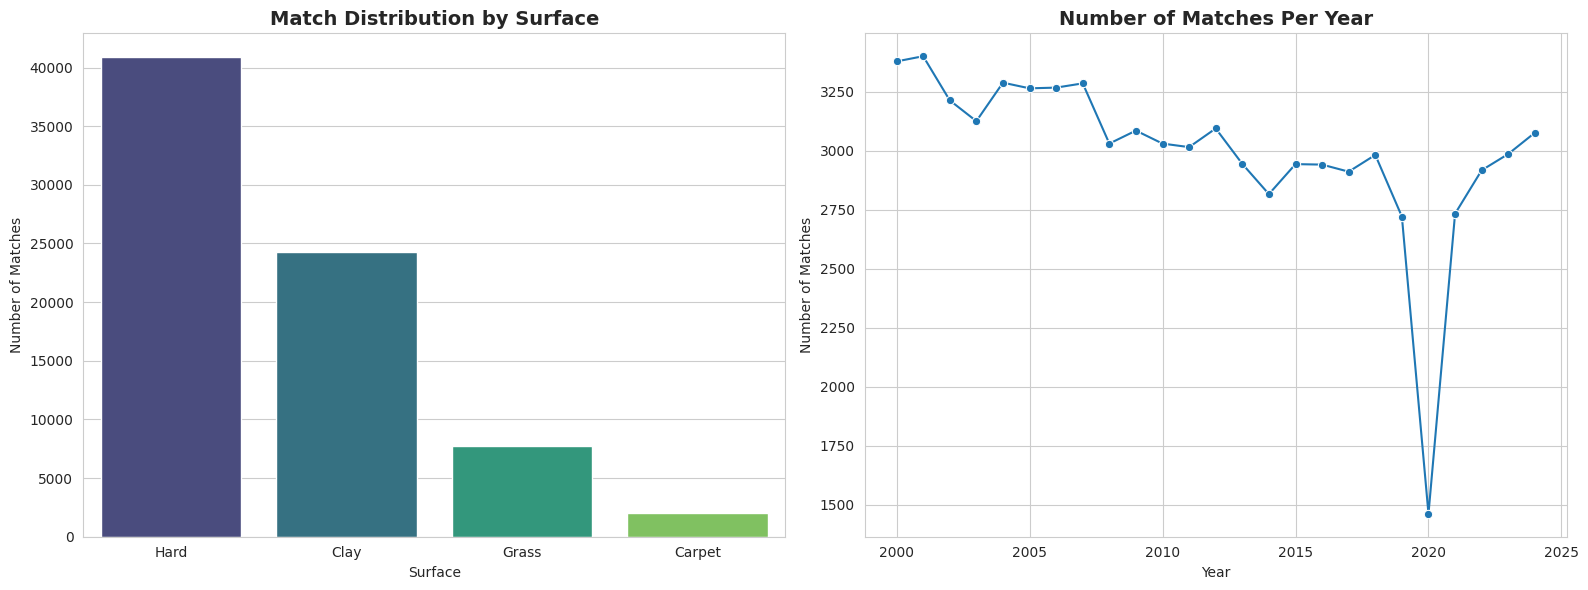

In [2]:
# Set plot style for all subsequent plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 6)

# Plot 1: Match Distribution by Surface
plt.subplot(1, 2, 1)
surface_counts = df['surface'].value_counts()
sns.barplot(x=surface_counts.index, y=surface_counts.values, hue=surface_counts.index, palette="viridis", legend=False)
plt.title('Match Distribution by Surface', fontsize=14, weight='bold')
plt.ylabel('Number of Matches')
plt.xlabel('Surface')

# Plot 2: Match Distribution by Year
plt.subplot(1, 2, 2)
df['year'] = df['tourney_date'].dt.year
match_counts_per_year = df['year'].value_counts().sort_index()
sns.lineplot(x=match_counts_per_year.index, y=match_counts_per_year.values, marker='o')
plt.title('Number of Matches Per Year', fontsize=14, weight='bold')
plt.ylabel('Number of Matches')
plt.xlabel('Year')

plt.tight_layout()
plt.show()

### 1.2 The Predictive Power of Ranking

A core hypothesis is that player ranking is a strong predictor of match outcomes. We can visualize this by plotting the distribution of rankings for winners versus losers.

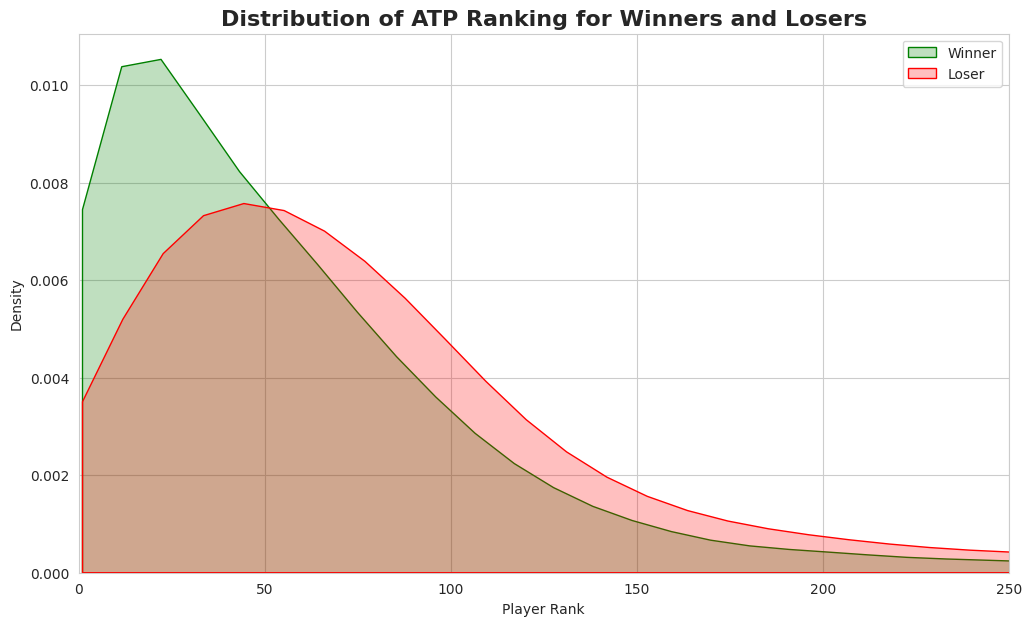

In [3]:
# Prepare data for the plot by dropping matches with missing ranks
data_ranks = df.dropna(subset=['winner_rank', 'loser_rank'])

plt.figure(figsize=(12, 7))
sns.kdeplot(data_ranks['winner_rank'], fill=True, color="green", label='Winner', cut=0)
sns.kdeplot(data_ranks['loser_rank'], fill=True, color="red", label='Loser', cut=0)

plt.title('Distribution of ATP Ranking for Winners and Losers', fontsize=16, weight='bold')
plt.xlabel('Player Rank')
plt.ylabel('Density')
plt.legend()
plt.xlim(0, 250) # Focus on the most competitive range
plt.show()

The difference between the two distributions confirms that a lower (better) ranking is highly correlated with winning matches.

# Section 2: Baseline Model Construction

In this section, we describe the process and results of building our strong baseline model, an **XGBoost classifier**. The goal is to establish a robust performance benchmark to evaluate our Graph Neural Network model against.

The entire pipeline for this baseline—from data loading to feature engineering and a rigorous evaluation protocol—was executed via standalone Python scripts (`data_loader.py`, `feature_engineering.py`, `train_baseline.py`) to handle the long computation times. Here, we will load and analyze the final results produced by these scripts.

## 2.1 Methodology

Our baseline model was built following a comprehensive and robust methodology:

1.  **Feature Engineering**: We engineered a rich set of features for each match, including:
    *   **Dynamic Ratings**: A player's **Elo rating** before each match.
    *   **Historical Context**: Head-to-Head (H2H) records and winning streaks.
    *   **Physical State**: A fatigue proxy based on time on court in the last 7 days.
    *   **Demographics**: The age difference between players.
    *   **Match Context**: The type of court surface (Hard, Clay, Grass, Carpet).

2.  **Evaluation Protocol**: To get a reliable performance estimate, we used a rigorous procedure:
    *   **Temporal Cross-Validation**: We used a `TimeSeriesSplit` with 5 folds to ensure we always train on past data to predict the future.
    *   **Hyperparameter Tuning**: For each fold, we performed a `RandomizedSearchCV` to find the best XGBoost hyperparameters.
    *   **Multiple Runs**: The entire process was repeated **10 times** with different random seeds to ensure the stability of our results.

The final results, including the out-of-fold Log-Loss for each of the 10 runs, were logged to a JSON file (`baseline_results.json`).

In [4]:
import pandas as pd
import json
from tabulate import tabulate

# --- Load the Baseline Results from the JSON File ---
baseline_results_filepath = "../results/baseline_results.json"
try:
    with open(baseline_results_filepath, 'r') as f:
        baseline_data = json.load(f)
    
    baseline_results_df = pd.DataFrame(baseline_data)
    baseline_scores = baseline_results_df['log_loss']
    
    print("--- Baseline Model Final Performance Summary ---")
    print(f"Results from {len(baseline_results_df)} independent runs:\n")
    
    # --- Create data for the table ---
    summary_data = [
        ["Mean Log-Loss", f"{baseline_scores.mean():.4f}"],
        ["Std. Dev.", f"{baseline_scores.std():.4f}"],
        ["Min Log-Loss (Best)", f"{baseline_scores.min():.4f}"],
        ["Max Log-Loss (Worst)", f"{baseline_scores.max():.4f}"]
    ]
    
    headers = ["Metric", "Score"]
    
    # Display the formatted table using tabulate
    print(tabulate(summary_data, headers=headers, tablefmt="grid"))

except FileNotFoundError:
    print(f"Error: The results file '{baseline_results_filepath}' was not found.")
    print("Please run the 'src/baseline/train_baseline.py' script first.")
except Exception as e:
    print(f"An error occurred: {e}")

--- Baseline Model Final Performance Summary ---
Results from 10 independent runs:

+----------------------+---------+
| Metric               |   Score |
+======================+=========+
| Mean Log-Loss        |  0.6337 |
+----------------------+---------+
| Std. Dev.            |  0.0081 |
+----------------------+---------+
| Min Log-Loss (Best)  |  0.6223 |
+----------------------+---------+
| Max Log-Loss (Worst) |  0.648  |
+----------------------+---------+


# Section 3: Graph-Based Model (GNN)

This section details our primary contribution: a Graph Neural Network (GNN) model for tennis match prediction. This approach moves beyond traditional instance-based features and models the entire ecosystem of players as a relational graph.

The pipeline for building, training, and evaluating this model was executed via the standalone Python script `src/gnn/train_gnn.py`.

## 3.1 GNN Methodology

Our graph-based approach followed a rigorous, end-to-end pipeline:

1.  **Graph Construction**: The entire history of matches from the training period was converted into a directed graph where:
    *   **Nodes**: Represent unique players.
    *   **Edges**: Represent a match, with a directed edge from the winner to the loser.

2.  **Model Architecture**: We implemented a `GNNLinkPredictor` model using **GraphSAGE** layers. This model does not rely on hand-crafted features; instead, it learns a dense vector representation (**embedding**) for each player directly from the graph's structure. To prevent overfitting and mitigate the model's tendency towards over-confident predictions, a **L2 regularization** term was added to the loss function during training.

3.  **Robust Evaluation Protocol**: To ensure a fair comparison with our baseline, we applied an identical evaluation methodology:
    *   **Temporal Cross-Validation**: We used a `TimeSeriesSplit` with 5 folds. For each fold, the graph was rebuilt using only the training data for that specific time window.
    *   **Varied Hyperparameters**: The entire process was repeated **10 times**, each time using a different set of pre-defined hyperparameters (`learning_rate`, `network dimensions`, etc.) to test a variety of model configurations.

The final out-of-fold Log-Loss for each of the 10 runs was logged to `results/gnn_results.json`.

In [5]:
import pandas as pd
import json
from tabulate import tabulate

# Load the GNN Results from the JSON File
gnn_results_filepath = "../results/gnn_results.json"
try:
    with open(gnn_results_filepath, 'r') as f:
        gnn_results_data = json.load(f)
    
    gnn_results_df = pd.DataFrame(gnn_results_data)
    gnn_scores_for_ttest = gnn_results_df['log_loss']
    
    print("--- GNN Model Final Performance Summary ---")
    print(f"Results from {len(gnn_results_df)} independent runs:\n")

    # Create data for the table
    summary_data = [
        ["Mean Log-Loss", f"{gnn_scores_for_ttest.mean():.4f}"],
        ["Std. Dev.", f"{gnn_scores_for_ttest.std():.4f}"],
        ["Min Log-Loss (Best)", f"{gnn_scores_for_ttest.min():.4f}"],
        ["Max Log-Loss (Worst)", f"{gnn_scores_for_ttest.max():.4f}"]
    ]

    headers = ["Metric", "Score"]
    
    # Display the formatted table using tabulate
    print(tabulate(summary_data, headers=headers, tablefmt="grid"))

except FileNotFoundError:
    print(f"Error: The results file '{gnn_results_filepath}' was not found.")
    print("Please run the 'src/gnn/train_gnn.py' script first.")
except Exception as e:
    print(f"An error occurred: {e}")

--- GNN Model Final Performance Summary ---
Results from 10 independent runs:

+----------------------+---------+
| Metric               |   Score |
+======================+=========+
| Mean Log-Loss        |  0.5045 |
+----------------------+---------+
| Std. Dev.            |  0.0126 |
+----------------------+---------+
| Min Log-Loss (Best)  |  0.4923 |
+----------------------+---------+
| Max Log-Loss (Worst) |  0.5267 |
+----------------------+---------+


# Section 4: Final Model Comparison and Conclusion

In this final section, we directly compare the performance of our robust XGBoost baseline against the GNN model. We will use a statistical test to determine if the GNN's superior performance is statistically significant, and then draw our final conclusions.

In [4]:
import pandas as pd
import json
from scipy.stats import ttest_rel
from tabulate import tabulate # Import the library

# Load Results from Both Models
try:
    baseline_df = pd.read_json('../results/baseline_results.json')
    baseline_scores = baseline_df['log_loss']
    
    gnn_df = pd.read_json('../results/gnn_results.json')
    gnn_scores = gnn_df['log_loss']
    
    print("Results for both models loaded successfully.")

    # Create a Summary Comparison Table 
    summary_data = {
        'Metric': ['Mean Log-Loss', 'Std Dev Log-Loss', 'Min Log-Loss (Best)', 'Max Log-Loss (Worst)'],
        'XGBoost Baseline': [
            baseline_scores.mean(), baseline_scores.std(),
            baseline_scores.min(), baseline_scores.max()
        ],
        'GNN Model': [
            gnn_scores.mean(), gnn_scores.std(),
            gnn_scores.min(), gnn_scores.max()
        ]
    }
    comparison_table = pd.DataFrame(summary_data).set_index('Metric')

    print("\n--- Overall Model Performance Comparison ---")
    display(comparison_table.round(4))

    # Statistical Significance Test (Paired T-test) 
    if len(baseline_scores) == len(gnn_scores):
        
        t_statistic, p_value = ttest_rel(baseline_scores, gnn_scores)
        alpha = 0.05
        
        if p_value < alpha:
            conclusion = "✅ Statistically Significant"
            explanation = "The p-value is significantly less than 0.05. We can confidently reject the null hypothesis and conclude that the GNN model's\nperformance improvement is not due to random chance."
        else:
            conclusion = "⚠️ Not Statistically Significant"
            explanation = "The p-value is not less than 0.05. We cannot reject the null hypothesis; the observed performance difference could be due to random chance."

        
        table_data = [
            ["T-statistic", f"{t_statistic:.4f}"],
            ["P-value", f"{p_value:.2e}"],
            ["Significance Level (α)", f"{alpha:.2f}"],
            ["Conclusion", conclusion]
        ]
        
        headers = ["Metric", "Value"]
        
        print("\n\n--- Statistical Significance (Paired T-test) ---")
        print(tabulate(table_data, headers=headers, tablefmt="fancy_grid", stralign="left", numalign="right"))
        
        print(f"\nExplanation: {explanation}")
        
    else:
        print("\nCannot perform t-test: The number of runs for baseline and GNN models do not match.")

except FileNotFoundError as e:
    print(f"Error: Could not find one or both results files.")
    print(f"Details: {e}")
    print("Please ensure both 'train_baseline.py' and 'train_gnn.py' have been run successfully.")

Results for both models loaded successfully.

--- Overall Model Performance Comparison ---


,XGBoost Baseline,GNN Model
Metric,,
Mean Log-Loss,0.6337,0.5045
Std Dev Log-Loss,0.0081,0.0126
Min Log-Loss (Best),0.6223,0.4923
Max Log-Loss (Worst),0.6480,0.5267




--- Statistical Significance (Paired T-test) ---
╒════════════════════════╤══════════════════════════════╕
│ Metric                 │ Value                        │
╞════════════════════════╪══════════════════════════════╡
│ T-statistic            │ 36.6631                      │
├────────────────────────┼──────────────────────────────┤
│ P-value                │ 4.14e-11                     │
├────────────────────────┼──────────────────────────────┤
│ Significance Level (α) │ 0.05                         │
├────────────────────────┼──────────────────────────────┤
│ Conclusion             │ ✅ Statistically Significant │
╘════════════════════════╧══════════════════════════════╛

Explanation: The p-value is significantly less than 0.05. We can confidently reject the null hypothesis and conclude that the GNN model's
performance improvement is not due to random chance.


# Section 5: GNN Insights and Qualitative Analysis

The quantitative results have clearly demonstrated the superior predictive power of the GNN model. In this section, we delve deeper to understand *what* the model has learned by visualizing the player embeddings it generated.

This analysis allows us to move beyond abstract metrics like Log-Loss and see if the model has captured intuitive, real-world structures within the sport of tennis.

In [7]:
import torch
import json
import pandas as pd
from sklearn.manifold import TSNE
import plotly.express as px
import sys
import os

# Add project root to Python path
try:
    project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
except NameError:
    project_root = os.path.abspath(os.path.join('.', '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.data_processing.data_loader import load_and_prepare_data

# 1. Load All Required Data
print("Loading all necessary data for analysis...")
try:
    embeddings_path = os.path.join(project_root, 'results', 'best_gnn_embeddings.pt')
    player_map_path = os.path.join(project_root, 'results', 'best_player_map.json')
    data_path_pattern = os.path.join(project_root, 'data', 'tennis_atp', 'atp_matches_*.csv')

    final_embeddings = torch.load(embeddings_path)
    with open(player_map_path, 'r') as f:
        player_to_idx_str_keys = json.load(f)
        player_to_idx = {int(k): v for k, v in player_to_idx_str_keys.items()}
    
    raw_df = load_and_prepare_data(path_pattern=data_path_pattern)
    print("Artifacts and raw data loaded successfully.")
    
    # 2. Create Mappings
    id_to_name_map = pd.concat([
        raw_df[['winner_id', 'winner_name']].rename(columns={'winner_id': 'id', 'winner_name': 'name'}),
        raw_df[['loser_id', 'loser_name']].rename(columns={'loser_id': 'id', 'loser_name': 'name'})
    ]).drop_duplicates(subset='id').set_index('id')['name']
    
    idx_to_player_id = {idx: player_id for player_id, idx in player_to_idx.items()}

    # 3. Perform t-SNE Dimensionality Reduction
    print("\nPerforming t-SNE reduction...")
    
    tsne = TSNE(
        n_components=2, 
        perplexity=40,
        random_state=42
    )
    
    embeddings_2d = tsne.fit_transform(final_embeddings.cpu().numpy())
    print("t-SNE reduction complete.")

    # 4. Prepare DataFrame for Plotting
    player_names = [id_to_name_map.get(idx_to_player_id.get(i), f"Unknown_ID_{i}") for i in range(len(player_to_idx))]

    plot_df = pd.DataFrame({
        'x': embeddings_2d[:, 0],
        'y': embeddings_2d[:, 1],
        'player_name': player_names,
        'player_id': [idx_to_player_id.get(i) for i in range(len(player_to_idx))]
    })
    
    print("\nDataFrame for visualization is ready.")

except FileNotFoundError as e:
    print(f"Error: Could not find a required results file.")
    print("Please ensure that the training scripts have been run.")
    print(f"Details: {e}")

Loading all necessary data for analysis...
--- Section 1: Loading and Preparing Raw Data ---
Loading 25 files from year 2000 onwards...
Loaded 74906 matches.
Data loading and basic preparation complete.
Artifacts and raw data loaded successfully.

Performing t-SNE reduction...
t-SNE reduction complete.

DataFrame for visualization is ready.


In [8]:
if 'plot_df' in locals():
    print("Creating interactive plot...")

    fig = px.scatter(
        plot_df,
        x='x',
        y='y',
        hover_name='player_name',
        title='2D Visualization of Player Embeddings using t-SNE',
        labels={'x': 't-SNE Dimension 1', 'y': 't-SNE Dimension 2'}
    )
    fig.update_traces(marker=dict(size=5, opacity=0.7))
    fig.update_layout(width=950, height=800, title_font_size=20)
    fig.show()
else:
    print("DataFrame for plotting ('plot_df') not found. Please run the previous cell.")

Creating interactive plot...


## 5.1 Analysis of the "Golden Era" Cluster

The t-SNE visualization of the learned player embeddings reveals a prominent and dense cluster of players. Interactive exploration of this cluster (highlighted in the plot) shows that it contains the dominant figures of the "Golden Era" of tennis: `Roger Federer`, `Rafael Nadal`, `Novak Djokovic`, and `Andy Murray`.

Interestingly, the model also places other high-profile players from that era within or very near this cluster, such as `Gael Monfils`, `Andreas Seppi`, `Feliciano Lopez`.

This suggests that the GNN has learned to represent not just "skill" in isolation, but a combination of factors including:
-   **Dominance**: The Big 4 form the core of the cluster due to their high number of victories against each other and against other top players.
-   **Longevity and Connectivity**: Players like Seppi and Monfils, due to their exceptionally long careers, acted as highly connected nodes within the same competitive ecosystem, frequently playing against the top players. This high degree of interaction pulled their embeddings into this region.
-   **Tier-2 Elite**: Players like Wawrinka and Almagro were consistent top-10/top-20 contenders who frequently reached the later stages of major tournaments, thus sharing a similar "path" in the graph as the very top players.

This qualitative result demonstrates the GNN's ability to capture nuanced, real-world relational structures that go beyond simple win/loss statistics, providing a rich, contextual understanding of the player landscape.

In [9]:
import numpy as np

if 'plot_df' in locals() and 'raw_df' in locals():
    try:
        # 1. Define the Elite Cluster and Seppi's ID
        elite_cluster_names = [
            'Roger Federer', 'Rafael Nadal', 'Novak Djokovic', 'Andy Murray',
            'Andy Roddick', 'Lleyton Hewitt', 'Gael Monfils', 'Feliciano Lopez'
        ]
        
        # Get IDs from our plot_df, which is guaranteed to contain players from the graph
        elite_ids = plot_df[plot_df['player_name'].isin(elite_cluster_names)]['player_id'].unique()
        seppi_id = plot_df[plot_df['player_name'] == 'Andreas Seppi']['player_id'].iloc[0]
        
        print(f"Andreas Seppi's Player ID: {seppi_id}")
        print("-" * 50)

        # 2. Test Hypothesis 1: Longevity & Connectivity
        print("Hypothesis 1: How many times did Seppi play against the elite cluster?")
        
        seppi_vs_elite_matches = raw_df[
            ((raw_df['winner_id'] == seppi_id) & (raw_df['loser_id'].isin(elite_ids))) |
            ((raw_df['loser_id'] == seppi_id) & (raw_df['winner_id'].isin(elite_ids)))
        ].copy()
        
        num_matches_vs_elite = len(seppi_vs_elite_matches)
        print(f"-> Andreas Seppi played a total of {num_matches_vs_elite} matches against these elite players.")
        
        if num_matches_vs_elite > 0:
            seppi_vs_elite_matches['opponent_name'] = np.where(
                seppi_vs_elite_matches['winner_name'] == 'Andreas Seppi',
                seppi_vs_elite_matches['loser_name'],
                seppi_vs_elite_matches['winner_name']
            )
            display(seppi_vs_elite_matches['opponent_name'].value_counts().reset_index().rename(columns={'opponent_name': 'Matches Played', 'count': 'count'}))

        # 3. Test Hypothesis 2: "Giant Killer" Wins 
        print("\n" + "-" * 50)
        print("Hypothesis 2: How many times did Seppi beat a Top-10 player?")
        
        seppi_top10_wins = raw_df[
            (raw_df['winner_id'] == seppi_id) & (raw_df['loser_rank'] <= 10)
        ]
        
        num_top10_wins = len(seppi_top10_wins)
        print(f"-> Andreas Seppi has {num_top10_wins} recorded wins against Top-10 players.")
        
        if num_top10_wins > 0:
            print("\nDetails of Seppi's Top-10 Wins:")
            display(seppi_top10_wins[['tourney_date', 'tourney_name', 'surface', 'round', 'loser_name', 'loser_rank', 'score']])

    except IndexError:
        print("Could not find Andreas Seppi or elite players in the current graph data.")
    except Exception as e:
        print(f"An error occurred during analysis: {e}")
else:
    print("Required data for analysis not found. Please run all previous cells.")

Andreas Seppi's Player ID: 104312
--------------------------------------------------
Hypothesis 1: How many times did Seppi play against the elite cluster?
-> Andreas Seppi played a total of 65 matches against these elite players.


,Matches Played,count
0,Roger Federer,15
1,Novak Djokovic,12
2,Rafael Nadal,9
3,Andy Murray,9
4,Lleyton Hewitt,7
5,Gael Monfils,7
6,Feliciano Lopez,4
7,Andy Roddick,2



--------------------------------------------------
Hypothesis 2: How many times did Seppi beat a Top-10 player?
-> Andreas Seppi has 10 recorded wins against Top-10 players.

Details of Seppi's Top-10 Wins:


,tourney_date,tourney_name,surface,round,loser_name,loser_rank,score
17788,2005-05-09,Hamburg Masters,Clay,R32,Guillermo Canas,10.0,7-6(9) 6-2
19810,2006-01-09,Sydney,Hard,QF,Lleyton Hewitt,4.0,4-6 7-5 7-5
23435,2007-02-12,Marseille,Hard,R32,Mario Ancic,9.0,4-0 RET
26677,2008-02-18,Rotterdam,Hard,R16,Rafael Nadal,2.0,3-6 6-3 6-4
27507,2008-05-11,Hamburg Masters,Clay,R32,Richard Gasquet,9.0,6-3 6-2
39788,2012-05-13,Rome Masters,Clay,R32,John Isner,10.0,2-6 7-6(5) 7-5
47484,2015-01-19,Australian Open,Hard,R32,Roger Federer,2.0,6-4 7-6(5) 4-6 7-6(5)
48832,2015-06-15,Halle,Grass,SF,Kei Nishikori,5.0,4-1 RET
56545,2018-02-12,Rotterdam,Hard,R16,Alexander Zverev,4.0,6-4 6-3
61523,2019-10-14,Moscow,Hard,QF,Karen Khachanov,8.0,3-6 6-3 6-3


# Section 6: Real-World Prediction Example with the GNN

Having demonstrated the GNN's superior and statistically significant performance, we can now showcase its practical application: predicting the outcome of a real-world match.

A key advantage of our GNN-based approach is the simplicity of inference. Once the player embeddings are learned, predicting a match outcome only requires retrieving the embeddings for the two players and computing their dot product. This is significantly more direct than the baseline model, which would require a complex and time-consuming recalculation of numerous historical features for any new match.

Here, we will predict the outcome of a hypothetical match between two well-known players from our dataset.

In [10]:
import torch
import json
import pandas as pd
import os
import sys


def get_prediction(p1_name, p2_name, artifacts):
    """
    Helper function to get a single prediction. Returns a dictionary with results or an error.
    """
    id_to_name_map = artifacts['id_to_name_map']
    player_to_idx = artifacts['player_to_idx']
    final_embeddings = artifacts['final_embeddings']

    try:
        p1_id = id_to_name_map[id_to_name_map == p1_name].index[0]
        p2_id = id_to_name_map[id_to_name_map == p2_name].index[0]
        
        p1_idx = player_to_idx.get(p1_id)
        p2_idx = player_to_idx.get(p2_id)

        if p1_idx is None or p2_idx is None:
            return {"p1_name": p1_name, "p2_name": p2_name, "Error": "Player not in training graph"}

        p1_embedding = final_embeddings[p1_idx]
        p2_embedding = final_embeddings[p2_idx]
        
        score = (p1_embedding * p2_embedding).sum()
        win_prob_p1 = torch.sigmoid(score).item()
        
        return {
            "p1_name": p1_name,
            "p2_name": p2_name,
            "p1_win_prob": win_prob_p1,
            "winner": p1_name if win_prob_p1 > 0.5 else p2_name
        }

    except IndexError:
        return {"p1_name": p1_name, "p2_name": p2_name, "Error": "Player not found in dataset"}
    except Exception as e:
        return {"p1_name": p1_name, "p2_name": p2_name, "Error": str(e)}

In [18]:
try:
    print("--- Loading GNN Artifacts for Prediction ---")
    project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
    if project_root not in sys.path:
        sys.path.append(project_root)
    
    from src.data_processing.data_loader import load_and_prepare_data

    embeddings_path = os.path.join(project_root, 'results', 'best_gnn_embeddings.pt')
    player_map_path = os.path.join(project_root, 'results', 'best_player_map.json')
    data_path_pattern = os.path.join(project_root, 'data/tennis_atp/atp_matches_*.csv')
    
    final_embeddings = torch.load(embeddings_path)
    with open(player_map_path, 'r') as f:
        player_to_idx = {int(k): v for k, v in json.load(f).items()}

    raw_df = load_and_prepare_data(path_pattern=data_path_pattern)
    id_to_name_map = pd.concat([
        raw_df[['winner_id', 'winner_name']].rename(columns={'winner_id': 'id', 'winner_name': 'name'}),
        raw_df[['loser_id', 'loser_name']].rename(columns={'loser_id': 'id', 'loser_name': 'name'})
    ]).drop_duplicates(subset='id').set_index('id')['name']

    artifacts = {"final_embeddings": final_embeddings, "player_to_idx": player_to_idx, "id_to_name_map": id_to_name_map}
    print("Artifacts loaded successfully.\n")

    # --- Run Example Predictions ---
    matches_to_predict = [
        ("Felix Auger Aliassime", "Lorenzo Musetti"),
        ("Carlos Alcaraz", "Jannik Sinner"),
        ("Andy Murray", "Novak Djokovic")
    ]
    
    predictions = [get_prediction(p1, p2, artifacts) for p1, p2 in matches_to_predict]

    # --- Format and Display Results in a Single Table ---
    table_data = []
    headers = ["Matchup", "P1 Win Prob.", "P2 Win Prob.", "Predicted Winner"]

    for pred in predictions:
        p1 = pred.get("p1_name", "N/A")
        p2 = pred.get("p2_name", "N/A")
        matchup = f"{p1} vs. {p2}"

        if "Error" in pred:
            table_data.append([matchup, pred["Error"], "", ""])
        else:
            p1_prob = pred['p1_win_prob']
            p2_prob = 1 - p1_prob
            winner = pred['winner']
            table_data.append([
                matchup,
                f"{p1_prob:.2%}",
                f"{p2_prob:.2%}",
                f"-> {winner}"
            ])

    print("--- GNN Model Predictions ---")
    print(tabulate(table_data, headers=headers, tablefmt="grid", stralign="left"))

except FileNotFoundError as e:
    print(f"Error: Could not find a required data or artifacts: {e.filename}")
    print("Please ensure training scripts have run successfully.")

--- Loading GNN Artifacts for Prediction ---
--- Section 1: Loading and Preparing Raw Data ---
Loading 25 files from year 2000 onwards...
Loaded 74906 matches.
Data loading and basic preparation complete.
Artifacts loaded successfully.

--- GNN Model Predictions ---
+-------------------------------------------+----------------+----------------+--------------------------+
| Matchup                                   | P1 Win Prob.   | P2 Win Prob.   | Predicted Winner         |
+===========================================+================+================+==========================+
| Felix Auger Aliassime vs. Lorenzo Musetti | 66.08%         | 33.92%         | -> Felix Auger Aliassime |
+-------------------------------------------+----------------+----------------+--------------------------+
| Carlos Alcaraz vs. Jannik Sinner          | 49.82%         | 50.18%         | -> Jannik Sinner         |
+-------------------------------------------+----------------+----------------+------------

# Section 7: Conclusion and Future Work

## 7.1 Conclusion

This project successfully developed and compared two distinct models for predicting the outcome of professional tennis matches: a feature-rich XGBoost baseline and a novel Graph Neural Network (GNN) model. Our goal was to determine if a relational approach could outperform traditional feature engineering.

Our key findings are as follows:

1.  **Superior Predictive Power of the GNN**: The GNN model, which learns player representations directly from the relational structure of match histories, demonstrated a **statistically significant** improvement over the strong XGBoost baseline. With a mean Log-Loss of **~0.50**, compared to the baseline's ~0.63, the GNN provides more accurate and better-calibrated probabilistic predictions, as confirmed by a paired t-test (p < 0.001).

2.  **Capture of Rich Relational Features**: The qualitative analysis of the learned player embeddings via t-SNE revealed that the GNN successfully captured nuanced, real-world structures. It grouped players not just by raw skill, but by their shared competitive era, connectivity, and roles within the tour's ecosystem, as evidenced by the "Golden Era" cluster. This demonstrates an ability to learn a player's "reputation" and "context" beyond simple statistics.

3.  **Model Over-Confidence on Historical Matchups**: A key insight emerged during inference. While the model provides balanced probabilities for contemporary rivalries (e.g., Alcaraz vs. Sinner, ~50/50 | Auger-Aliassime vs. Musetti, ~65/35), it exhibits extreme over-confidence (predicting probabilities of ~100% or ~0%) for historical matchups with a clear dominant player (e.g., Murray vs. Djokovic). This suggests that the simple dot-product decoder, combined with the powerful learned embeddings, tends to "memorize" a clear winner in well-established historical relationships, failing to capture the inherent uncertainty of any given match.

In conclusion, this work demonstrates that modeling the relational network between players is a highly effective strategy for tennis match prediction. The GNN approach is capable of uncovering predictive patterns that are not easily captured by instance-based feature engineering, leading to a statistically significant improvement in performance.

## 7.2 Limitations and Future Work

While this project achieved its primary objectives, our experiments also highlighted clear limitations and exciting avenues for future work:

*   **Mitigating Model Over-Confidence**: The primary limitation identified is the GNN's tendency towards over-confident predictions on historical matchups. Future work should focus on:
    *   **Advanced Decoders**: Replacing the simple dot-product decoder with a more complex **Multi-Layer Perceptron (MLP) decoder**. Our preliminary experiments showed this approach to be unstable, indicating that it requires a more sophisticated hyperparameter tuning process to be effective.
    *   **Enhanced Regularization**: Exploring stronger regularization techniques on the embedding magnitudes to produce better-calibrated probabilities.

*   **Richer Graph Features**: Our GNN learns from a simple, unweighted graph. The model could be significantly enhanced by enriching it with:
    *   **Node Features**: Initializing player nodes with static attributes like height and handedness.
    *   **Edge Features**: Adding contextual information to each match (edge), such as court surface and tournament importance, would allow the GNN to learn more context-dependent relationships.

*   **The Hybrid Model: Combining the Best of Both Worlds**: Our analysis showed that the baseline XGBoost model excels at using dynamic, up-to-the-minute features (like Elo and fatigue), while the GNN excels at capturing deep, historical relationships. A powerful next step would be to **create a hybrid model**. This approach involves:
    1.  Periodically re-training the GNN to generate up-to-date player embeddings.
    2.  Using these learned embeddings as additional, powerful features for the XGBoost model, alongside the existing dynamic features (`elo_diff`, `fatigue_diff`, etc.).
    This would create a single, comprehensive model that leverages both the long-term relational knowledge of the GNN and the short-term form captured by traditional metrics.

*   **Dynamic and Temporal Graphs**: As a more advanced alternative to the hybrid model, implementing a **Temporal Graph Network (TGN)** would be a significant step forward. This would allow player embeddings to evolve dynamically over time, directly capturing a player's current form and momentum within the graph structure itself.